# Generative Adversarial Network (GAN) with CNN Implementation

### Introduction
A generative adversarial network (GAN) is a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in 2014.

The generative network generates candidates while the discriminative network evaluates them. The contest operates in terms of data distributions. 

Typically, the generative network learns to map from a latent space to a data distribution of interest, while the discriminative network distinguishes candidates produced by the generator from the true data distribution. 

The generative network's training objective is to increase the error rate of the discriminative network (i.e., "fool" the discriminator network by producing novel candidates that the discriminator thinks are not synthesized (are part of the true data distribution)).

### Goal
You have seen how a linear GAN is implemented in class (gan_illus.ipynb) where the GAN is constructed with a linear generator and a linear discriminator.

In this HW, we are going to construct a convolutional-based GAN with the MNIST dataset and try to find some optimal paramaters for the GAN to reach Nash equilibrium.

## Please note the 20% extra credit at the end

## Set up the environment

In [116]:
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
plt.rcParams['figure.figsize'] = [12, 6]


## Download the MNIST datasets from Prof. Jacob's google drive

In [117]:
# Uncomment and run the following  once to download the files. Note where the data is copied to. Comment it back; you dont need to run it again
!gdown --id '1fAW-pvhBWiXxE-H-WEOurS1Ta4V5mYe0'
!gdown --id '1zSVOn9lJa4eF-jubtZwdtO-t0UScnJk0'

Downloading...
From: https://drive.google.com/uc?id=1fAW-pvhBWiXxE-H-WEOurS1Ta4V5mYe0
To: /content/mnist_train.pickle
47.5MB [00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zSVOn9lJa4eF-jubtZwdtO-t0UScnJk0
To: /content/mnist_test.pickle
7.92MB [00:00, 124MB/s]


## Once copied, load them to python


In [118]:
import pickle
with open('/content/mnist_train.pickle', 'rb') as data:
    mnist_train = pickle.load(data)
with open('/content/mnist_train.pickle', 'rb') as data:
    mnist_test = pickle.load(data)


## Selecting only digits 0,..,MaxLabels to reduce computational complexity

In [119]:
MaxLabels = 10
mnist_data_reduced = mnist_train
idx = mnist_train.train_labels<MaxLabels
mnist_data_reduced.data = mnist_train.data[idx]
mnist_data_reduced.targets = mnist_train.targets[idx]

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## Construct the generator
The following is where we define the generator of the infoGAN.

References:

  1. infoGAN paper: https://arxiv.org/abs/1606.03657

  2. infoGAN development: https://machinelearningmastery.com/how-to-develop-an-information-maximizing-generative-adversarial-network-infogan-in-keras/


In [120]:
class generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32,base_size=64):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size


        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

## Construct the discriminator
The following is where we define the discriminator of the GAN.


In [121]:
class discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32,base_size=64):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x


## Define a function to initialize the weights of the network


In [122]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

## Function to display the results


In [123]:

def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
        s=ax[i].imshow(np.squeeze(samples[i,]))
        s=ax[i].get_xaxis().set_visible(False)
        s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()


## Construct the GAN (FILL IN THE SECTION BELOW)

##GAN training using binary cross entropy loss

GAN performs the following <font color=red>min-max</font> optimization
$$\max_{D}\min_{G}\Big(\log\left(D(x_{\rm real})\right) y_{\rm real} + \log\left(D(x_{\rm fake})\right) y_{\rm fake}\Big), $$

which is equivalent to 
$$\min_{D}\max_{G}  \Big({\rm BCE}\left(D(x_{\rm real}),\underbrace{y_{\rm real}}_{1}\right) + {\rm BCE}\left(D(\underbrace{x_{\rm fake}}_{G[z]}),\underbrace{y_{\rm fake}}_0\right)\Big)
$$

The GAN optimization alternates between the following steps. 

1. Discriminator optimization $\min_{D}  \Big({\rm BCE}\left(D(x_{\rm real}),\underbrace{y_{\rm real}}_{1}\right) + {\rm BCE}\left(D(\underbrace{x_{\rm fake}}_{G[z]}),\underbrace{y_{\rm fake}}_0\right)\Big)
$

<font color=red>The discriminator optimization aims to assign $D(x_{\rm real}) \rightarrow 1$ and $D(x_{\rm fake}) \rightarrow 0$ </font>.

2. Generator optimization $\min_{G}  ~{\rm BCE}\left(D(\underbrace{x_{\rm fake}}_{G[z]}),\underbrace{y_{\rm real}}_1\right)$

<font color=red>The generator tries to assign $D(x_{\rm fake}) \rightarrow 1$ </font>.

See the comments of GAN_illus.ipynb for details.



In [124]:
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

        # load dataset
        self.data_loader = torch.utils.data.DataLoader(mnist_data_reduced, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        # initialization of the generator and discriminator
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']))
        
        # initialization of the loss function

        self.BCE_loss = nn.BCELoss().cuda()
        
        # Gettng a batch of noise to generate the fake data
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim)).cuda()
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):

       # Setting empty arrays for storing the losses

        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        # Epoch loops

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                # Generate random noise to push through the generator   

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()
                x_= x_+torch.normal(mean=0,std=0.1,size=x_.shape).cuda()
                z_=z_+torch.normal(mean=0,std=0.1,size=z_.shape).cuda()


                # YOUR CODE HEREE
                #--------------------

                # update D network using 
                # 1. Set optimizer gradient to zero
                # 2. Set discriminator losses on real and fake data
                # 3. Do back propagation to compute gradients
                # 4. Make a step of D_optimizer
                # 5. Set the current loss in self.train_hist['D_loss]
                self.D_optimizer.zero_grad()
                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)
                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)
                D_loss = D_real_loss + D_fake_loss
                D_loss.backward()
                self.D_optimizer.step()
                
                # update G network using 
                # 1. Set optimizer gradient to zero
                # 2. Set generator losses on fake data
                # 3. Do back propagation to compute gradients
                # 4. Make a step of G_optimizer
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.G_optimizer.zero_grad()
                G_ = self.G(z_)
                D_fake = self.D(G_)
                G_loss = self.BCE_loss(D_fake,self.y_real_)
                G_loss.backward()
                self.G_optimizer.step()



                # Print iterations and losses
                print("Iteration ",iter,"D AND G loss",D_loss,G_loss)
                self.train_hist['D_loss'].append(D_loss.item())
                self.train_hist['G_loss'].append(G_loss.item())

                if ((iter + 1) % 50) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
                
            # Visualize results
            with torch.no_grad():
                 visualize_results(self)

        print("Training finished!")




## Train the GAN (TODO)
Here, one set of paramaters are provided to you.

You can try to change the paramater to see if you can get a better results. Also, you are welcome to utilize the strategies you learned in class and used in previous homeworks.

Some of the ideas could be:

  1. modify the structure of the discriminator and the generator by changing base_size and input dimension

  2. change the parameter of the optimizer (e.g. lr_g, lr_d, momentum terms) or the optimizer itself (e.g Stochastic gradient descent) to get better/worse convergence.

  4. One approach to improve GANs is to add noise to the input and fake images before feeding to the discriminator. This will smooth the data manifold and the fake manifolds, thus minimizing the risk of vanishing gradients. We will use LSGAN and/or Wasserstein GAN formulations to minimize these risks in a more systematic fashion.
  
  5. One sided label smoothing.
  https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b

The final grading is not based on how many modifications you add but how well the generator loss and the discriminator loss reach the nash equilibrium. So only keep the modifications that you think are necessary.

In [125]:
params = {'beta1': 0.5, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':30}
params['z_dim'] =2
params['base_size'] = 64

gan = GAN(params)
gan.train()

training start!!
Iteration  0 D AND G loss tensor(1.4269, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0735, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Iteration  1 D AND G loss tensor(1.5954, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Iteration  2 D AND G loss tensor(1.5345, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Iteration  3 D AND G loss tensor(1.5125, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9677, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Iteration  4 D AND G loss tensor(1.5393, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9714, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Iteration  5 D AND G loss tensor(1.5648, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9732, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Iteration  6 D AND G loss tensor(1.5831, device='cuda:0', grad_fn=<AddB

KeyboardInterrupt: ignored

# Show embedding. Only works if the number of latent variables is of dimension 2 

<Figure size 2880x2880 with 0 Axes>

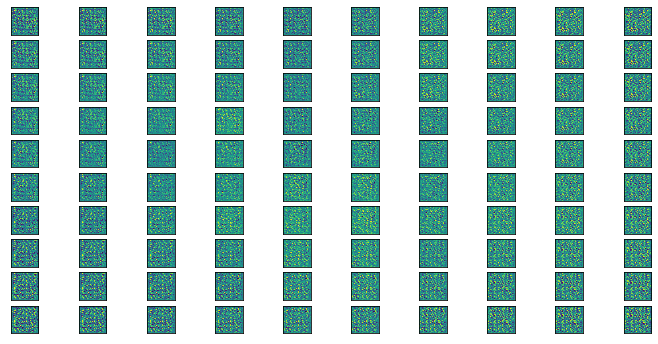

In [126]:
mtx_size = 10
[x,y] = np.meshgrid(np.linspace(0,1,10),np.linspace(1,0,10))
embedding = np.stack((x.ravel(),y.ravel()))
embedding = torch.tensor(embedding).T.cuda()
embedding = embedding.type(torch.cuda.FloatTensor)
recons = gan.G(embedding)
recons = recons.detach().cpu().numpy()

recons.shape
plt.figure(figsize=(40, 40))
fig,ax = plt.subplots(mtx_size,mtx_size)

i = 0
for x in range(mtx_size):
  for y in range(mtx_size):
    i = x*mtx_size + y
    ax[x][y].imshow(np.reshape(recons[i,],(28,28)))
    ax[x][y].get_xaxis().set_visible(False)
    ax[x][y].get_yaxis().set_visible(False)

## Extra Credit (20 % points)

Most of the above comparisons were visual. It is very hard to completely 
Combine the trained generator with an encoder and only optimize the encoder parameters, keeping the decoder/generator parameters fixed. 

This would give you an auto-encoder, which can be used to assess the MSE loss.

Now try to optimize the MSE loss and report back your results.